In [1]:
import numpy as np
from skimage import io

from numpy.lib.stride_tricks import sliding_window_view

from matplotlib import pyplot as plt

from skimage import io, color, filters, morphology, util
from skimage.measure import EllipseModel
from skimage.color import rgb2gray
from skimage import filters, util
from skimage.morphology import disk, skeletonize, ball
from skimage.measure import approximate_polygon
from skimage import transform
import copy
from PIL import Image, ImageDraw, ImageFilter, ImageOps

from matplotlib import cm
import networkx as nx
from tqdm.notebook import tqdm

from bresenham import bresenham
from matplotlib import cm, colors
import matplotlib.patches as mpatches
from collections import Counter
import pandas as pd

from shapely.geometry import Polygon, LineString
import rasterio.features
import matplotlib.pyplot as plt

from networkx.drawing import draw_networkx
import itertools
from numpy import linalg as LA

from multiprocessing import Lock, Process, Queue, current_process
import multiprocessing
import pickle

import cv2
from mpire import WorkerPool
import time
import shutil
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path
import json

import psutil
import math
import os
import subprocess

from wc_cv.src.utils import grainPreprocess, grainMark, SEMDataset, grainDraw, Crack

from pathos.multiprocessing import ProcessingPool as Pool  # Alternative parallelization


# No labeled data process

/tmp/ipykernel_566388/2710032787.py:13: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  nodes_metadata)  = Crack.preprocess_graph_image(image, border=border, disk=5)


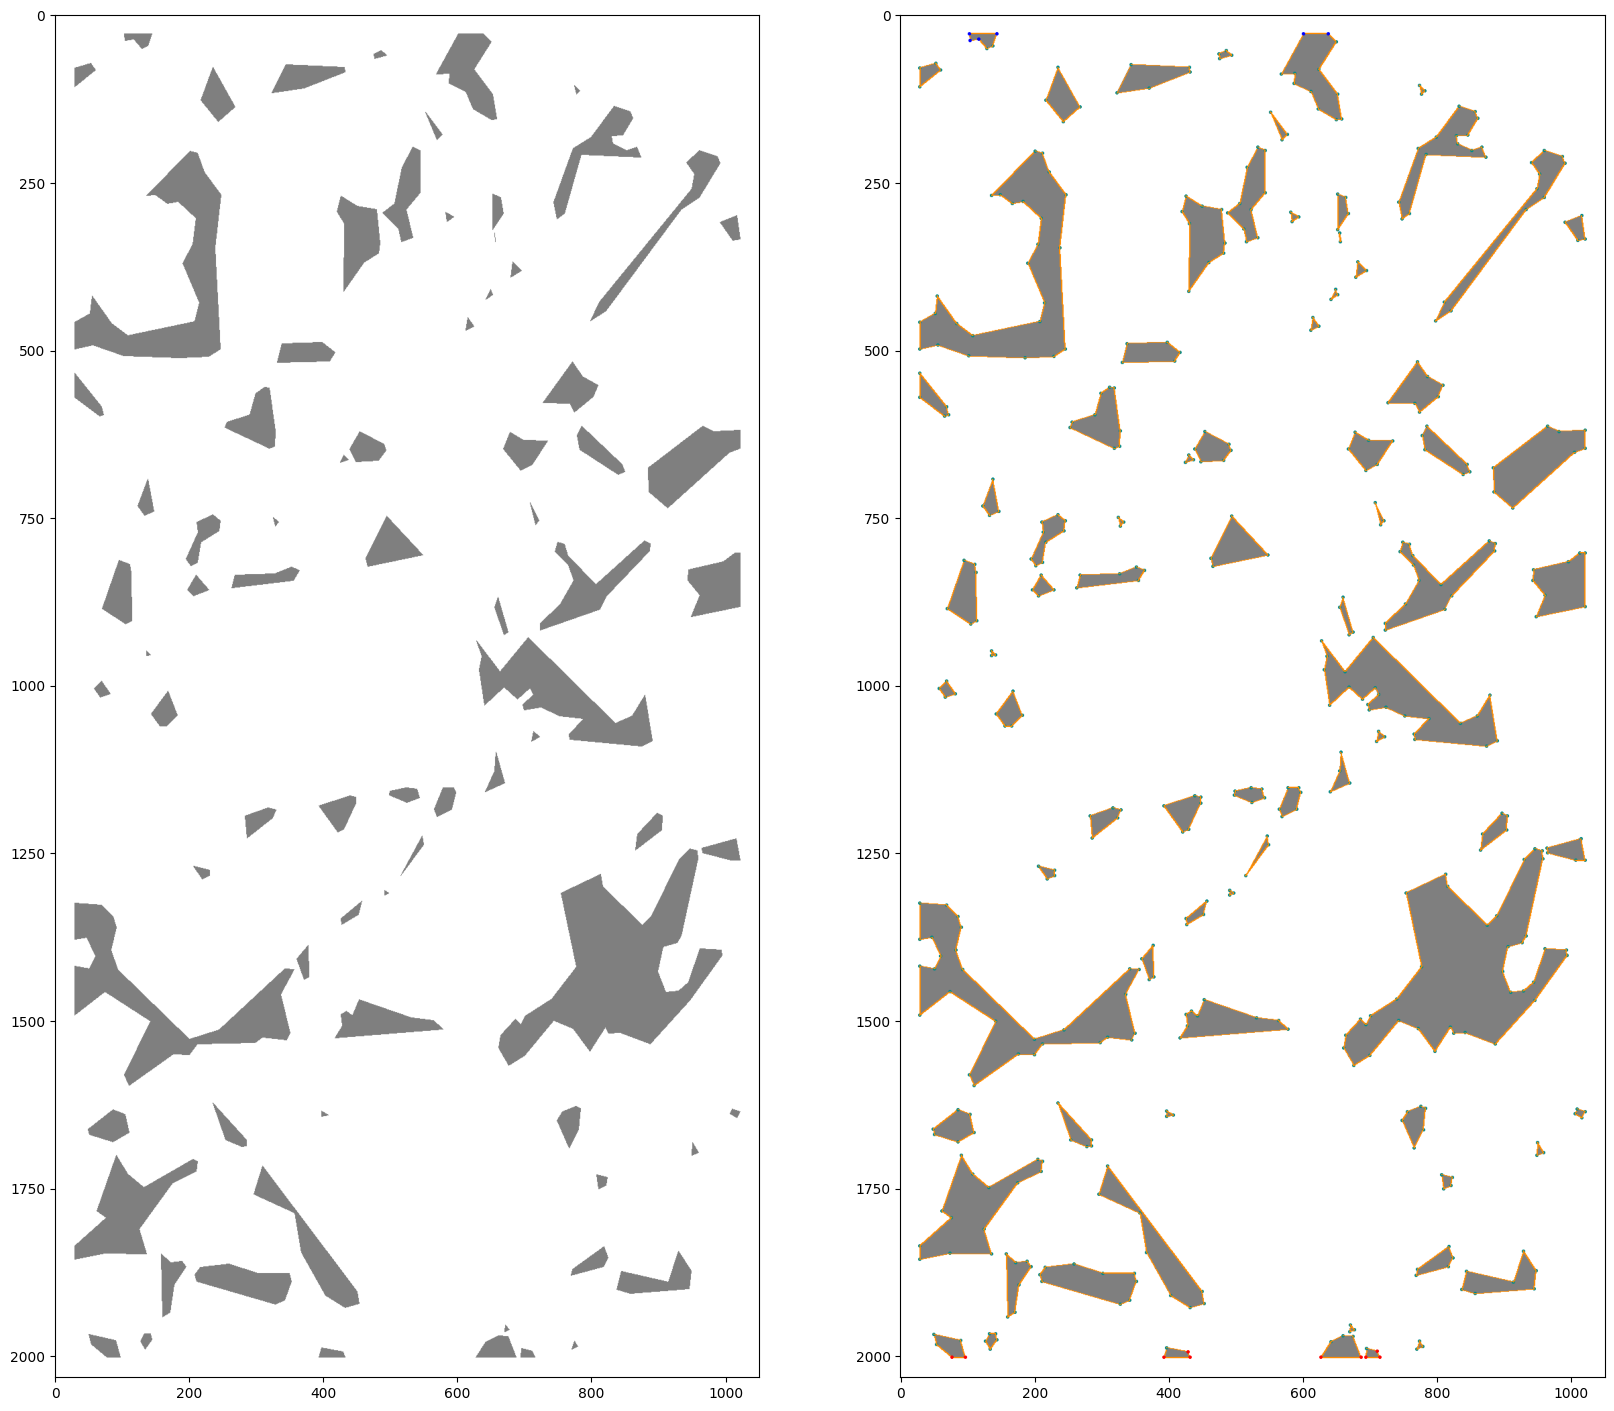

In [2]:
eps = 300
# image = io.imread('wc_cv/cv/plots/WC+8Co_5_crack.jpg')[200:-300]
# image = io.imread('wc_cv/cv/plots/WC+8Co_5_crack.jpg')[200:-300]
image = io.imread('wc_cv/cv/plots/WC+8Co_5_fixed_001_cropped.jpg')

border=30

(entry_nodes,
 exit_nodes,
 img_contours,
 img_preprocessed_final,
 cnts,
 nodes_metadata)  = Crack.preprocess_graph_image(image, border=border, disk=5)

plot=True

if plot:
    fig, axes = plt.subplots(1,2,figsize=(20,20))
    axes[0].imshow(img_contours)
    axes[1].imshow(img_preprocessed_final)
    # plt.savefig('miniature_figures_aligned_crack.jpg', bbox_inches='tight')

    # axes[0].set_ylim(1000,1700)
    # axes[1].set_ylim(1000,1700)
    plt.show()

g, img_contours =  Crack.create_crack_graph(img_preprocessed_final.shape, cnts, nodes_metadata, eps=eps)

In [ ]:
save=False
# save=True

Crack.Viz.graph_plot(g, img_preprocessed_final, name='test.jpg', save=save)

In [ ]:
# df['path'] = df['path'].apply(lambda x: np.array(x))
# df.to_csv('shortest_paths_edges.csv')

In [ ]:
def find_shortest_energy_paths( G, cnts, nodes_metadata,  entry_node, exit_node): 
    all_paths=[]
    all_entry_nodes=[]
    all_exit_nodes=[]
    all_path_len_edges=[]
    all_path_len_pixels=[]
    
    all_wc_edges = []
    all_co_edges = []
    all_wc_co_edges = []

    all_wc_edges_lens = []
    all_co_edges_lens = []
    all_wc_co_edges_lens = []
    
    all_wc_pixels = []
    all_co_pixels = []
    all_wc_co_pixels = []
    
    paths =  [list(nx.shortest_path(G, source=entry_node, target=exit_node, weight = 'weight'))]

    for path in paths: 
        all_paths.append(path)
        all_entry_nodes.append(int(entry_node))
        all_exit_nodes.append(int(exit_node))
        all_path_len_edges.append(len(path))
        l=nx.path_weight(G, path, 'weight')
        all_path_len_pixels.append(l)
        
        points_stack = np.stack([path, np.roll(path,shift=-1,axis=0)],axis=1)[:-1]

        types = []
        edges_lens=[]
        for points in points_stack:
            node1,node2 = points
            edges_lens.append(nx.path_weight(G,[node1,node2], 'weight'))
            edge_type = Crack.get_edge_type(node1,
                                            node2,
                                            cnts,
                                            nodes_metadata)
            types.append(edge_type)
            
        
        types = np.array(types)
        edges_lens = np.array(edges_lens)
        
        wc_edges_indices = np.where(types==0)[0]
        co_edges_indices = np.where(types==2)[0]
        wc_co_edges_indices = np.where(types==1)[0]

        wc_pixels_lens=edges_lens[wc_edges_indices]
        co_pixels_lens=edges_lens[co_edges_indices]
        wc_co_pixels_lens=edges_lens[wc_co_edges_indices]
        z = np.sum(edges_lens)
            
        all_wc_edges.append(len(wc_edges_indices)/len(path))
        all_co_edges.append(len(co_edges_indices)/len(path))
        all_wc_co_edges.append(len(wc_co_edges_indices)/len(path))

        all_wc_edges_lens.append(len(wc_pixels_lens))
        all_co_edges_lens.append(len(co_pixels_lens))
        all_wc_co_edges_lens.append(len(wc_co_pixels_lens))
        
        all_wc_pixels.append(np.sum(wc_pixels_lens)/z)
        all_co_pixels.append(np.sum(co_pixels_lens)/z)
        all_wc_co_pixels.append(np.sum(wc_co_pixels_lens)/z)

    return pd.DataFrame({'path':all_paths,
                            'path_len_edges':all_path_len_edges,
                            'energy': np.round(all_path_len_pixels,2),
                            
                            'entry_node':all_entry_nodes,
                            'exit_node':all_exit_nodes,
                            
                            'wc_edges': np.round(all_wc_edges,2),
                            'co_edges':np.round( all_co_edges,2),
                            'wc_co_edges': np.round(all_wc_co_edges,2),
                            
                            'wc_pixels': np.round(all_wc_pixels,2), 
                            'co_pixels': np.round(all_co_pixels,2), 
                            'wc_co_pixels': np.round(all_wc_co_pixels,2), 

                            'wc_num': all_wc_edges_lens,
                            'co_num': all_co_edges_lens,
                            'wc_co_num': all_wc_co_edges_lens,
                        })


In [56]:
%%time

# entry_nodes = [ 0,3,4, 11]
# exit_nodes = [ 84, 30, 31]

# WC+8Co_5_fixed_001_cropped.jpg
entry_nodes = [ 4, 15, 13, 16, 34, 27]
exit_nodes = [ 527, 528, 519, 522]

# WC+8Co_5_crack
# entry_nodes = [ 4, 11, 16, 61, 62, 66]
# exit_nodes = [ 307, 308, 515, 529]


# edge types
# 0 - Co
# 1 - WC-Co
# 2 - WC
# 3 - WC-WC

co_co_e_max=20
wc_co_e_max=20

# modify the energies of edges

cart_list=[entry_nodes, exit_nodes]
cart_list=[element for element in itertools.product(*cart_list)]

tasks_data=[]
step=0
for i,co_co_e in enumerate(tqdm(range(0,co_co_e_max))):
    for j,wc_co_e in enumerate(range(0,wc_co_e_max)):
        energy = {
            0: co_co_e, # Co
            1: wc_co_e, # WC-Co
            2: 20, # WC
            } 
        
        g_weighed = copy.deepcopy(g)
        
        for u, v in g_weighed.edges():
            path_len = g.edges[u,v]['path_len']
            edge_type = g.edges[u,v]['edge_type']
            e=energy[edge_type]
            g_weighed[u][v]['weight'] = path_len*e

        cart_list_tmp=[(g_weighed, cnts, nodes_metadata, line[0],line[1]) for line in cart_list]
        for k, line in enumerate(cart_list_tmp):
            tasks_data.append(cart_list_tmp)
            grid_dict[step]=(i,j,k)
            step+=1

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 10.2 s, sys: 0 ns, total: 10.2 s
Wall time: 10.2 s


In [ ]:
workers=20

with WorkerPool(n_jobs=workers) as pool:
    results = pool.map( find_shortest_energy_paths, tasks_data, progress_bar = True)

In [70]:
energies=np.zeros((len(cart_list), co_co_e_max, wc_co_e_max)).tolist()

for p in range(step):
    i,j,k=grid_dict[p]
    energies[k][i][j]=results[i]

In [84]:
pd.DataFrame(energies[3][k][p],columns=[
                                    'path',
                                    'path_len_edges',
                                    'path_len_pixels',
                                    'energy',
                                    'entry_node',
                                    'exit_node',
                                    'wc_edges',
                                    'co_edges',
                                    'wc_co_edges',
                                    'wc_pixels',
                                    'co_pixels',
                                    'wc_co_pixels',
                                    'wc_num',
                                    'co_num',
                                    'wc_co_num',
                                    'index'])['energy']

0    20679.79
Name: energy, dtype: float64

  0%|          | 0/5 [00:00<?, ?it/s]

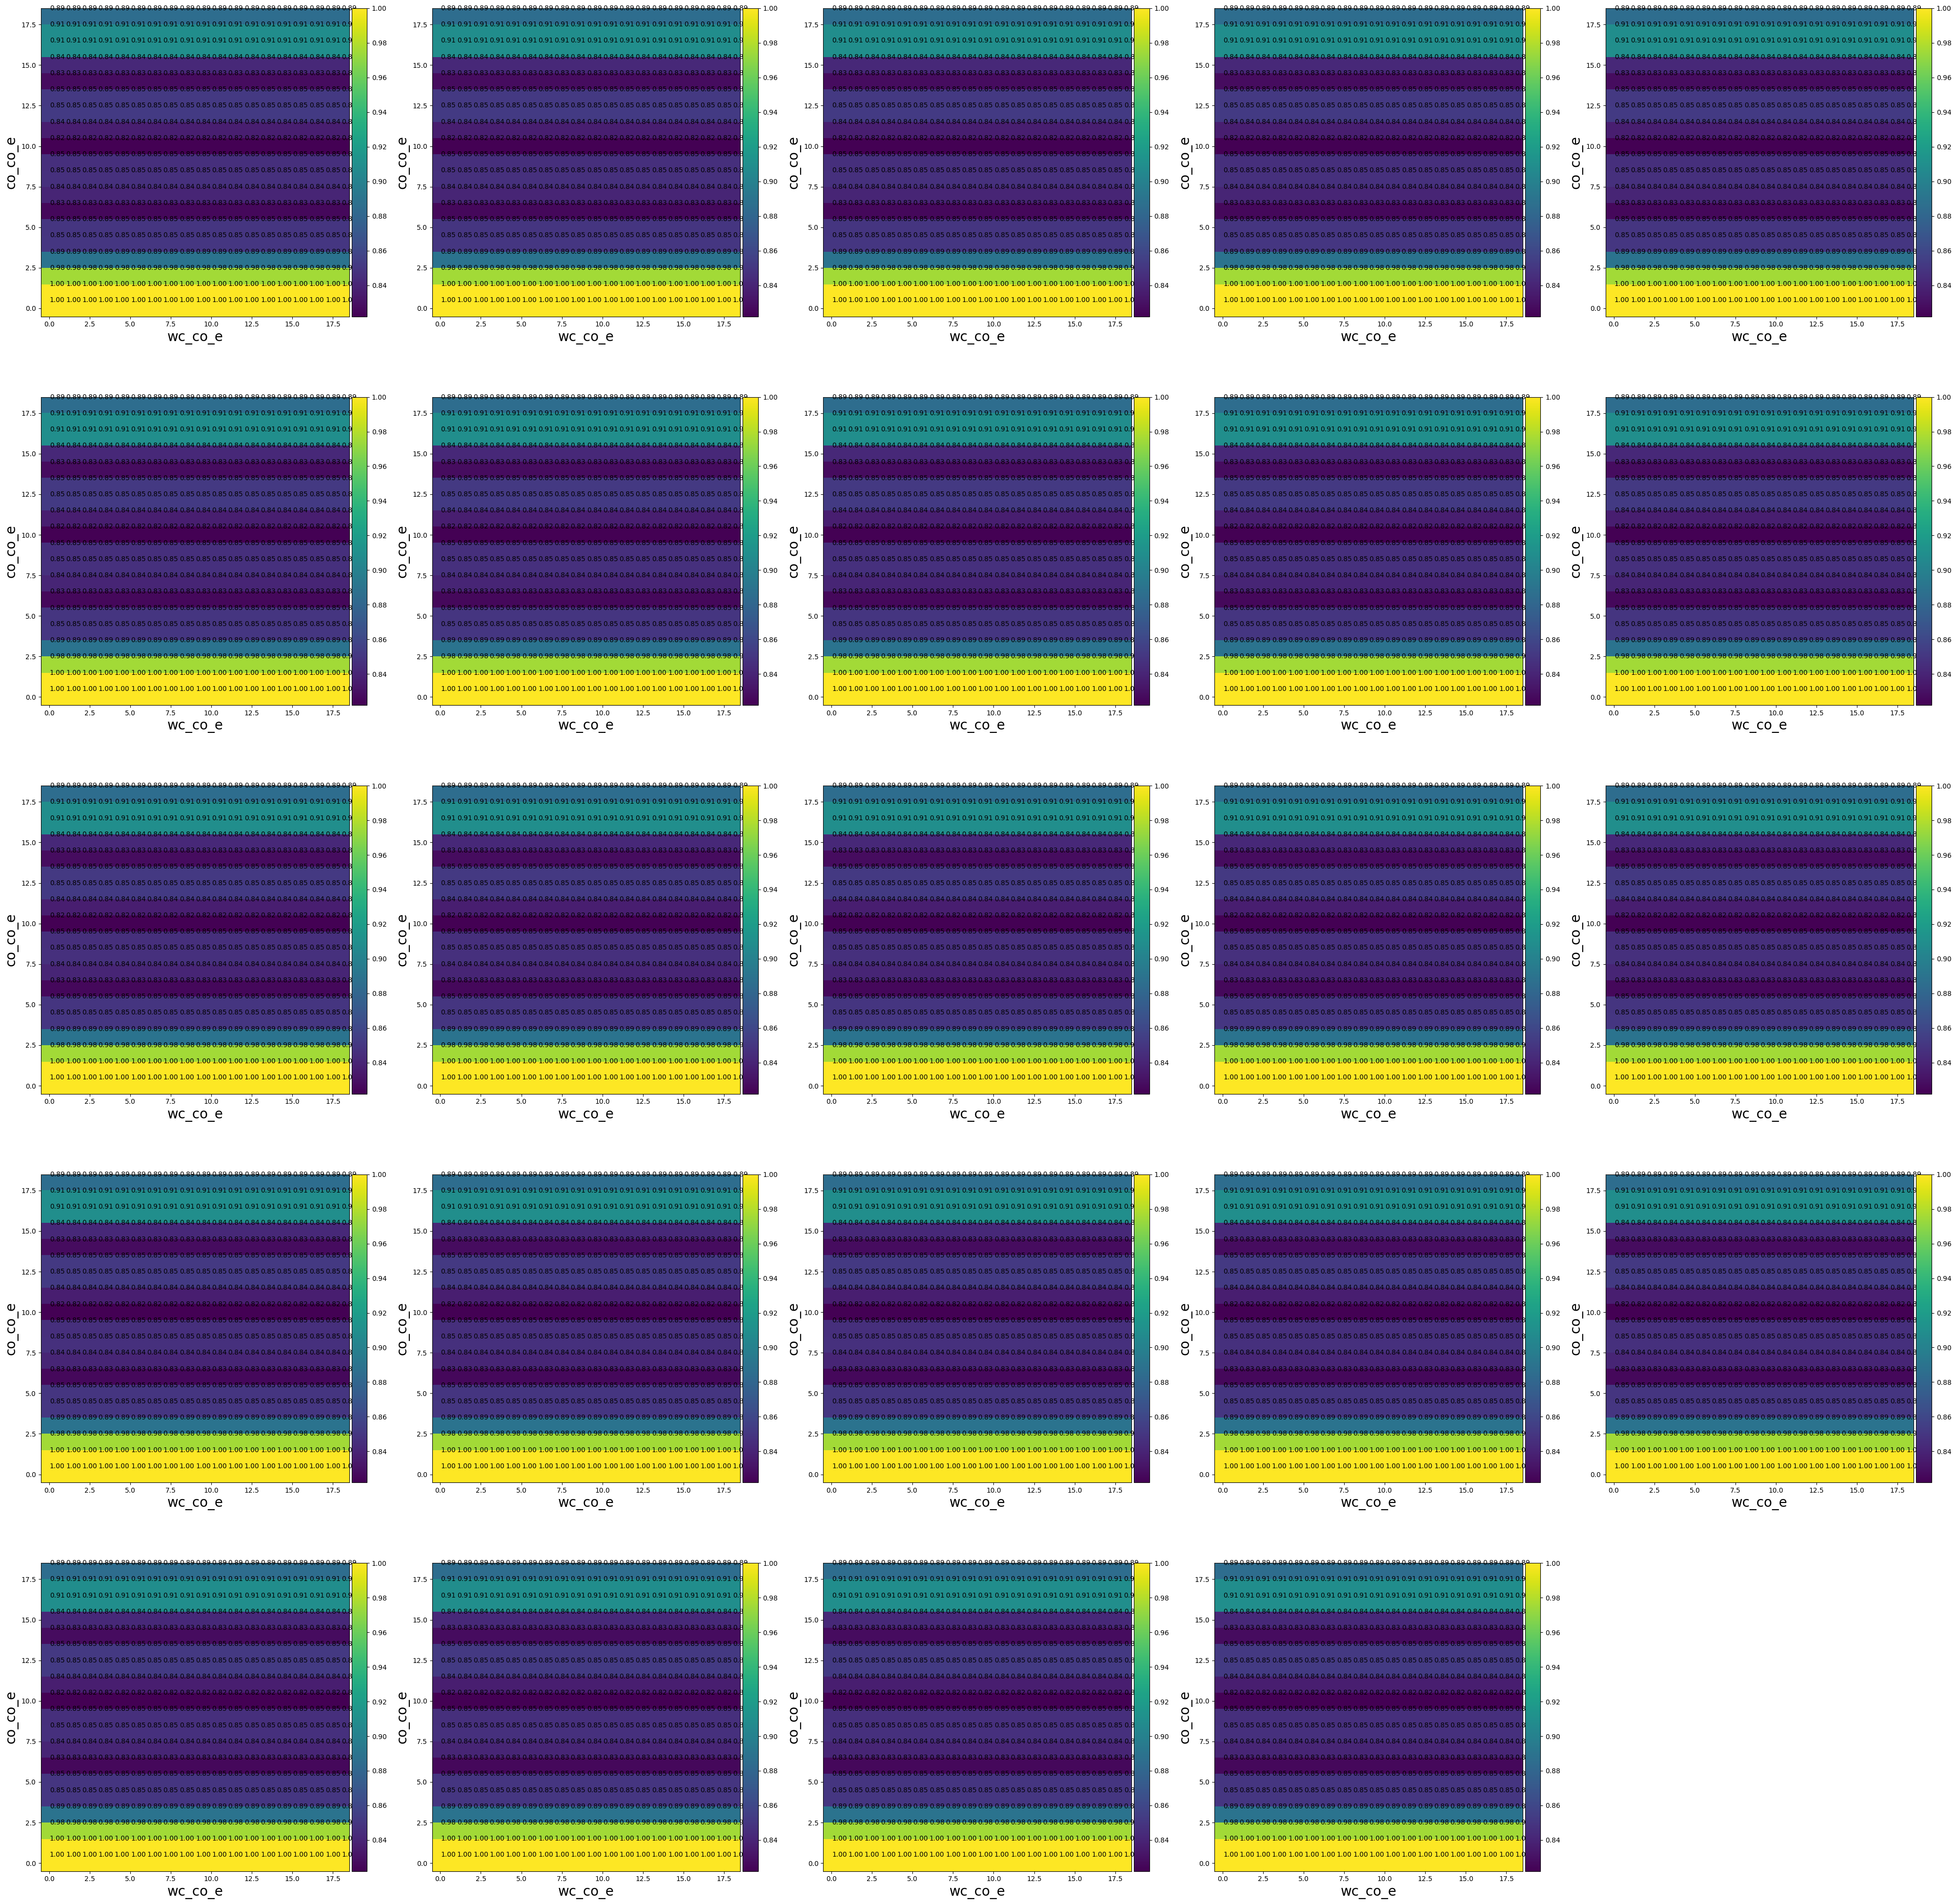

In [74]:
N=5
M=5

fig, axes = plt.subplots(N, M, figsize=(50, 50))

step=0
# vertical lines subplots 
for i in tqdm(range(N)):
    # horizontal lines subplots 
    for j in range(M):      
        energy_grid=[]  
        # iterate over all entry-exit paths pairs
        # step is a pair index
        # BUG, [0,0] sometimes is bigger, then [0,1]
        if step<len(cart_list):

            for k,co_co_e in enumerate(range(1,co_co_e_max)):
                energy_grid.append([])
                
                for p,wc_co_e in enumerate(range(1,wc_co_e_max)):
                    df = pd.DataFrame(energies[step][k][p],columns=[
                                    'path',
                                    'path_len_edges',
                                    'path_len_pixels',
                                    'energy',
                                    'entry_node',
                                    'exit_node',
                                    'wc_edges',
                                    'co_edges',
                                    'wc_co_edges',
                                    'wc_pixels',
                                    'co_pixels',
                                    'wc_co_pixels',
                                    'wc_num',
                                    'co_num',
                                    'wc_co_num',
                                    'index'])
                    val = df['energy'].iloc[0]
                    energy_grid[k].append(val)
            
            data = np.array(energy_grid)
            data = data/np.max(data)
            im = axes[i,j].imshow(data)

            # axes[i,j].set_title(f'entry {dfs[k][p]["entry_node"].values[step]}, exit {dfs[k][p]["exit_node"].values[step]}', fontsize=20)

            divider = make_axes_locatable(axes[i,j])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im, cax=cax, orientation='vertical')
        
            axes[i,j].invert_yaxis()
            for k,co_co_e in enumerate(range(1,co_co_e_max)):
                for p,wc_co_e in enumerate(range(1,wc_co_e_max)):
                    axes[i,j].text(k + 0.5, p + 0.5, '%.2f' % data[p, k],
                    horizontalalignment='center',
                    verticalalignment='center',
                    )
                    
            axes[i,j].set_ylabel(f'co_co_e',  fontsize=20)
            axes[i,j].set_xlabel(f'wc_co_e',  fontsize=20)

            step+=1
        else:
            fig.delaxes(axes[i][j])

# if save:
#     plt.savefig(name,  bbox_inches='tight')

plt.show()

In [ ]:
%%time

# entry_nodes = [ 0,3,4, 11]
# exit_nodes = [ 84, 30, 31]

# WC+8Co_5_fixed_001_cropped.jpg
entry_nodes = [ 4, 15, 13, 16, 34, 27]
exit_nodes = [ 527, 528, 519, 522]

# WC+8Co_5_crack
# entry_nodes = [ 4, 11, 16, 61, 62, 66]
# exit_nodes = [ 307, 308, 515, 529]

# edge types
# 0 - Co
# 1 - WC-Co
# 2 - WC
# 3 - WC-WC

co_co_e_max=20
wc_co_e_max=20

dfs=[]
for i,co_co_e in enumerate(tqdm(range(1,co_co_e_max))):
    dfs.append([])
    for j,wc_co_e in enumerate(range(1,wc_co_e_max)):
        energy = {
                  0: co_co_e, # Co
                  1: wc_co_e, # WC-Co
                  2: 20, # WC
                  } 
        # df = Crack.Energy.get_energies(g, cnts, nodes_metadata, entry_nodes, exit_nodes, energy)
        df = get_energies(g, cnts, nodes_metadata, entry_nodes, exit_nodes, energy)
        dfs[i].append(df)

In [ ]:
# name='wc_cv/cv/WC+8Co_5_fixed_001_cropped_optimized_e.jpg'
name='wc_cv/cv/WC+8Co_5_crack_optimized_e.jpg'

save=True
# save=False


Crack.Viz.plot_optimized_energies(dfs, N=5,M=5,
                                  co_co_e_max=20,
                                  wc_co_e_max=20,
                                  name=name,
                                  save=save)

In [ ]:
# io.imsave('wc_cv/cv/img_preprocessed_final_no_artefact.jpg',img_preprocessed_final[1000:1700])

In [ ]:
# save graph object to file
# pickle.dump(g, open('g.pickle', 'wb'))

# nx.write_edgelist(g,'350x500.txt',data=False)

# Label-studio image preprocess

In [ ]:
bin = img_contours==255
bin = bin[:,:,0]
bin = bin.astype(np.uint8)

image = io.imread('wc_cv/cv/WC+8Co_5_fixed_001_cropped.jpg')
image = color.rgb2gray(image)*255
image = np.pad(image, border, SEMDataset.pad_with)

tmp_img = image*bin
tmp_img = tmp_img.astype(np.uint8)

img_drawings = copy.copy(Image.fromarray(tmp_img)).convert('RGB')
img_drawings = grainDraw.draw_contours(img_drawings, cnts=cnts, color_corner=(0, 139, 139), color_line = (255, 140, 0),corners = True, r=5)

# io.imsave('wc_cv/cv/fixed_cropped_crack_sub.jpg',img_drawings)

plt.imshow(img_drawings)
img_drawings.save('wc_cv/cv/fixed_cropped_crack_sub.jpg')

# labeled data input


In [ ]:
with open('wc_cv/cv/wc_co_labeled.json') as f:
    data = json.load(f)[0]

labeled_cnts = []
labels = []

for i in range(len(data['annotations'][0]['result'])):
    width = data['annotations'][0]['result'][i]['original_width']
    height = data['annotations'][0]['result'][i]['original_height']
    cnt = np.array(data['annotations'][0]['result'][i]['value']['points'])
    cnt[:,0]*=width/100
    cnt[:,1]*=height/100
    labeled_cnts.append(cnt.astype(np.int32))
    labels.append(data['annotations'][0]['result'][i]['value']['polygonlabels'][0])

labels = np.array(labels)

# image is used only for shape
image = io.imread('wc_cv/cv/fixed_cropped_crack_sub.jpg')

border=30
eps = 300

(entry_nodes,
 exit_nodes,
 img_contours,
 img_preprocessed_final,
 cnts,
 nodes_metadata)  = Crack.preprocess_graph_image(image,
                                                 border=border,
                                                 disk=5,
                                                 labeled_cnts=labeled_cnts,
                                                 labels=labels)



In [ ]:

fig, axes = plt.subplots(1,2,figsize=(20,20))
axes[0].imshow(img_contours)
axes[1].imshow(img_preprocessed_final[250:1250])
# plt.savefig('miniature_figures_aligned_crack.jpg', bbox_inches='tight')
plt.show()

In [ ]:
# with open('wc_cv/cv/nodes_metadata.pkl', 'wb') as f:
#     pickle.dump(nodes_metadata, f)

In [ ]:
# with open('wc_cv/cv/wc_co_labeled.json') as f:
#     data = json.load(f)[0]

# labeled_cnts = []
# labels = []

# for i in range(len(data['annotations'][0]['result'])):
#     width = data['annotations'][0]['result'][i]['original_width']
#     height = data['annotations'][0]['result'][i]['original_height']
#     cnt = np.array(data['annotations'][0]['result'][i]['value']['points'])
#     cnt[:,0]*=width/100
#     cnt[:,1]*=height/100
#     labeled_cnts.append(cnt.astype(np.int32))
#     labels.append(data['annotations'][0]['result'][i]['value']['polygonlabels'][0])

# labels = np.array(labels)

# img_preprocessed_final_shape = np.array((2032, 1051, 3))
# eps = 300

# with open('wc_cv/cv/nodes_metadata.pkl', 'rb') as f:
#     nodes_metadata = pickle.load(f)

# g, _ =  Crack.create_crack_graph(img_preprocessed_final_shape,
#                                              labeled_cnts,
#                                              nodes_metadata,
#                                              eps=eps,
#                                              labels = labels)

In [ ]:
with open('wc_cv/cv/wc_co_labeled.json') as f:
    data = json.load(f)[0]

labeled_cnts = []
labels = []

for i in range(len(data['annotations'][0]['result'])):
    width = data['annotations'][0]['result'][i]['original_width']
    height = data['annotations'][0]['result'][i]['original_height']
    cnt = np.array(data['annotations'][0]['result'][i]['value']['points'])
    cnt[:,0]*=width/100
    cnt[:,1]*=height/100
    labeled_cnts.append(cnt.astype(np.int32))
    labels.append(data['annotations'][0]['result'][i]['value']['polygonlabels'][0])

labels = np.array(labels)

g, _ =  Crack.create_crack_graph(img_preprocessed_final.shape,
                                             cnts,
                                             nodes_metadata,
                                             eps=eps,
                                             labels = labels)

In [ ]:
def graph_plot(g, img_contours,N=50,M=50, name ='graph.jpg', border = 30, save=False, node_size=500, with_labels=True, fontsize=25):
    # 0 - Co
    # 1 - WC-Co
    # 2 - WC
    # 3 - WC-WC

    color_dict={0:'red',
                1:'orange',
                2:'blue',
                3:'green'}
    

    colors=[]
    for u,v in g.edges():
        edge_type = g[u][v]['edge_type']
        colors.append(color_dict[edge_type])

    img_tmp = np.array(img_contours)
    
    pos = nx.get_node_attributes(g, 'pos')
    fig,axes = plt.subplots(1,1,figsize=(N,M))
    
    nx.draw(g, pos, ax =axes,  with_labels=with_labels, node_color='lightblue', node_size=node_size, font_size=15, edge_color=colors)


    axes.imshow(img_tmp, cmap='gray')
    
    # axes[0].invert_yaxis()
    # axes[1].invert_yaxis()
    
    plt.axis("on")
    axes.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    plt.xticks(np.arange(0,img_tmp.shape[1],100), fontsize=fontsize)
    plt.yticks(np.arange(0,img_tmp.shape[0],100),fontsize=fontsize)
    
    axes.arrow(5, 0, 5, img_tmp.shape[0], width=0.3, length_includes_head=True, head_width=10, head_length=10,color=(0,0,0))
    axes.text(-20, img_tmp.shape[0]*2/3,'hit direction',rotation=90, color=(0, 0, 0),fontsize=fontsize)
    
    # axes.text(img_tmp.shape[1]/2 - border, - 2*border,'entry nodes', color=(0, 0, 1),fontsize=fontsize)
    # axes.text(img_tmp.shape[1]/2 - border,img_tmp.shape[0]+ 2*border,'exit nodes', color=(1, 0, 0),fontsize=fontsize)

    path1 = mpatches.Patch(color='red', label='Co, type 0')
    path2 = mpatches.Patch(color='orange', label='WC-Co, type 1')
    path3 = mpatches.Patch(color='blue', label='WC, type 2')
    path4 = mpatches.Patch(color='green', label='WC-WC, type 3')
    
    # plt.legend(handles=[path1,path2,path3,path4],fontsize=fontsize)

    plt.legend(handles=[path1,path2,path3,path4], bbox_to_anchor=(0.74, 0.865), bbox_transform=axes.transAxes)


    if save:
        plt.savefig(name, bbox_inches='tight')
        
    plt.show()

In [ ]:
plot=False
# plot=True

# edges_to_remove = [(a,b) for a, b, attrs in g.edges(data=True) if attrs["edge_type"] == 2]

# g_cleaned=copy.deepcopy(g)

# g_cleaned.remove_edges_from(edges_to_remove)

g_cleaned=copy.deepcopy(g)

# Crack.Viz.graph_plot(g_cleaned, img_contours,N=150,M=150, name='wc_cv/cv/wc_co_labeled_graph.jpg', save=plot)
graph_plot(g_cleaned, img_contours,N=25,M=25, name='wc_cv/cv/wc_co_labeled_graph.jpg', save=plot, node_size=30, with_labels=False, fontsize=15)

In [ ]:
%%time

# entry_nodes = [ 0,3,4, 11]
# exit_nodes = [ 84, 30, 31]

# WC+8Co_5_fixed_001_cropped.jpg
# entry_nodes = [ 4, 15, 13, 16, 34, 27]
# exit_nodes = [ 527, 528, 519, 522]

# WC+8Co_5_crack
# entry_nodes = [ 4, 11, 16, 61, 62, 66]
# exit_nodes = [ 307, 308, 515, 529]

# WC+8Co_5_crack hand labeled
# entry_nodes = [ 636, 635, 625, 639, 642, 698]
# exit_nodes = [ 399, 398, 1092, 109]

# WC+8Co_5_crack hand labeled, no WC movement
# entry_nodes = [ 636, 635, 625, 639, 642, 698]
entry_nodes = [ 636, 635, 625, 639, ]
exit_nodes = [ 399, 398, 1092]

## ADD nodes paths existance check


# edge types
# 0 - Co
# 1 - WC-Co
# 2 - WC
# 3 - WC-WC

co_co_e_max=20
wc_co_e_max=20


edges_to_remove = [(a,b) for a, b, attrs in g.edges(data=True) if attrs["edge_type"] == 2]

g_cleaned=copy.deepcopy(g)

g_cleaned.remove_edges_from(edges_to_remove)

dfs=[]
for i,co_co_e in enumerate(tqdm(range(1,co_co_e_max))):
    dfs.append([])
    for j,wc_co_e in enumerate(range(1,wc_co_e_max)):
        energy = {
                  0: co_co_e, # Co
                  1: wc_co_e, # WC-Co
                  2: 2000, # WC
                  3: 10, # WC-WC
                  } 
        df = Crack.Energy.get_energies(g_cleaned, cnts, nodes_metadata, entry_nodes, exit_nodes, energy)
        dfs[i].append(df)

In [ ]:
entry_nodes = [ 636, 635, 625, 639]
exit_nodes = [ 399, 398, 1092,109]

nx.shortest_path(g_cleaned, source=entry_nodes[2], target=exit_nodes[3])

In [ ]:
# name='wc_cv/cv/WC+8Co_5_fixed_001_cropped_optimized_e.jpg'
name='wc_cv/cv/WC+8Co_5_crack_fixed_optimized_e_labeled_no_wc_10.jpg'

save=True
# save=False


Crack.Viz.plot_optimized_energies(dfs, N=5,M=5,
                                  co_co_e_max=20,
                                  wc_co_e_max=20,
                                  name=name,
                                  save=save)

In [ ]:
pickle.dump(g, open('wc_cv/cv/test_graph.pickle', 'wb'))

# Fixed paths energies 

In [ ]:
def get_paths_energies(G, paths):
    
    all_paths=[]
    all_entry_nodes=[]
    all_exit_nodes=[]
    all_path_len_edges=[]
    all_path_len_pixels=[]
    
    all_wc_edges = []
    all_co_edges = []
    all_wc_co_edges = []

    all_wc_edges_lens = []
    all_co_edges_lens = []
    all_wc_co_edges_lens = []
    
    all_wc_pixels = []
    all_co_pixels = []
    all_wc_co_pixels = []

    for i in range(len(paths)):
        entry_node, exit_node = paths.iloc[i]['entry_node'], paths.iloc[i]['exit_node']
        path =  paths.iloc[i]['path']
        
        all_paths.append(path)
        all_entry_nodes.append(int(entry_node))
        all_exit_nodes.append(int(exit_node))
        all_path_len_edges.append(len(path))
        
        # calculating energy
        l=nx.path_weight(G, path, 'weight')
        all_path_len_pixels.append(l)
        
        points_stack = np.stack([path, np.roll(path,shift=-1,axis=0)],axis=1)[:-1]

        types = []
        edges_lens=[]
        for points in points_stack:
            node1,node2 = points
            edges_lens.append(nx.path_weight(G,[node1,node2], 'weight'))
            edge_type = Crack.get_edge_type(node1,
                                            node2,
                                            cnts,
                                            nodes_metadata)
            types.append(edge_type)
            
        
        types = np.array(types)
        edges_lens = np.array(edges_lens)
        
        wc_edges_indices = np.where(types==0)[0]
        co_edges_indices = np.where(types==2)[0]
        wc_co_edges_indices = np.where(types==1)[0]

        wc_pixels_lens=edges_lens[wc_edges_indices]
        co_pixels_lens=edges_lens[co_edges_indices]
        wc_co_pixels_lens=edges_lens[wc_co_edges_indices]
        z = np.sum(edges_lens)
            
        all_wc_edges.append(len(wc_edges_indices)/len(path))
        all_co_edges.append(len(co_edges_indices)/len(path))
        all_wc_co_edges.append(len(wc_co_edges_indices)/len(path))

        all_wc_edges_lens.append(len(wc_pixels_lens))
        all_co_edges_lens.append(len(co_pixels_lens))
        all_wc_co_edges_lens.append(len(wc_co_pixels_lens))
        
        all_wc_pixels.append(np.sum(wc_pixels_lens)/z)
        all_co_pixels.append(np.sum(co_pixels_lens)/z)
        all_wc_co_pixels.append(np.sum(wc_co_pixels_lens)/z)

    return pd.DataFrame({'path':all_paths,
                         'path_len_edges':all_path_len_edges,
                         'path_len_pixels': np.round(all_path_len_pixels,2),
                         'energy': np.round(all_path_len_pixels,2),
                         
                         'entry_node':all_entry_nodes,
                         'exit_node':all_exit_nodes,
                         
                         'wc_edges': np.round(all_wc_edges,2),
                         'co_edges':np.round( all_co_edges,2),
                         'wc_co_edges': np.round(all_wc_co_edges,2),
                         
                         'wc_pixels': np.round(all_wc_pixels,2), 
                         'co_pixels': np.round(all_co_pixels,2), 
                         'wc_co_pixels': np.round(all_wc_co_pixels,2), 

                         'wc_num': all_wc_edges_lens,
                         'co_num': all_co_edges_lens,
                         'wc_co_num': all_wc_co_edges_lens,
                        })


def get_e_fixed_optimized_paths(g, paths, energy, workers=23):
    
    # modify the energies of edges
    g_weighed = g.copy()
    
    for u, v in g_weighed.edges():
        path_len = g.edges[u,v]['path_len']
        edge_type = g.edges[u,v]['edge_type']
        e=energy[edge_type]
        g_weighed[u][v]['weight'] = path_len*e

    # find the minimal energy paths
    results = get_paths_energies(g_weighed, paths)
    
    df = copy.copy(results)
    
    df['index'] = range(len(df))
    df.set_index('index')
    
    
    return df

In [ ]:
%%time

N=36
workers=23

np.random.seed(51)

# WC+8Co_5_crack
# entry_nodes = [ 4, 11, 16, 61, 62, 66]
# exit_nodes = [ 307, 308, 515, 529]

# WC+8Co_5_fixed_001_cropped.jpg
entry_nodes = [ 4, 15, 13, 16, 34, 27]
exit_nodes = [ 527, 528, 519, 522]

# hand labeled data
entry_nodes = [ 636, 635, 625, 639, ]
exit_nodes = [ 399, 398, 1092]

energy_o = {0: 10, # WC-WC
            1: 7, # WC-Co
            2: 7 # Co-Co
            3: 10, # WC-WC
           } 

g_weighed = g.copy()

for u, v in g_weighed.edges():
    path_len = g.edges[u,v]['path_len']
    edge_type = g.edges[u,v]['edge_type']
    e=energy_o[edge_type]
    g_weighed[u][v]['weight'] = path_len*e


# get all paths
cart_list=[entry_nodes, exit_nodes]
cart_list=[element for element in itertools.product(*cart_list)]
cart_list=[(g_weighed,cnts, nodes_metadata, line[0],line[1]) for line in cart_list]


with WorkerPool(n_jobs=workers) as pool:
    results = pool.map(Crack.Energy.find_shortest_energy_paths, cart_list, progress_bar= True)

dfs_o = pd.concat(results,axis=0)

# paths_indices = np.random.choice(range(len(dfs_o)), N)
# print(paths_indices)
# paths = dfs_o[paths_indices]
paths = copy.copy(dfs_o)

dfs=[]
print(1)
# calculate energy heatmp for nodes cartesian product
for i,co_co_e in enumerate(tqdm(range(1,20))):
    dfs.append([])
    for j,wc_co_e in enumerate(range(1,20)):
        energy = {
                  0: co_co_e, # Co
                  1: wc_co_e, # WC-Co
                  2: 20, # WC
                  3: 10, # WC-WC
                  } 
        df = get_e_fixed_optimized_paths(g, paths, energy)
        dfs[i].append(df)

In [ ]:
energy_grid=[]

# dfs=np.load('dfs_crack_fixed.npy',allow_pickle=True)
# dfs=np.load('dfs_crack.npy',allow_pickle=True)

N,M=5,5

fig, axes = plt.subplots(N, M, figsize=(50, 50))

step=0
for i in tqdm(range(N)):
    for j in range(M):      
        energy_grid=[] 
        if step<len(dfs[0][0]):
            for k,co_co_e in enumerate(range(1,20)):
                energy_grid.append([])
                
                for p,wc_co_e in enumerate(range(1,20)):
                    df = pd.DataFrame(dfs[k][p],columns=[
                                    'path',
                                    'path_len_edges',
                                    'path_len_pixels',
                                    'energy',
                                    'entry_node',
                                    'exit_node',
                                    'wc_edges',
                                    'co_edges',
                                    'wc_co_edges',
                                    'wc_pixels',
                                    'co_pixels',
                                    'wc_co_pixels',
                                    'wc_num',
                                    'co_num',
                                    'wc_co_num',
                                    'index'])
                    val = df['energy'].iloc[step]
                    energy_grid[k].append(val)
            
            data = np.array(energy_grid)
            data = data/np.max(data)
            im = axes[i,j].imshow(data)
            
            axes[i,j].set_title(f'pix {dfs[k][p]["path_len_pixels"].values[step]}, edg { dfs[k][p]["path_len_edges"].values[step] }, entry {dfs[k][p]["entry_node"].values[step]}, exit {dfs[k][p]["exit_node"].values[step]}', fontsize=20)
            
            divider = make_axes_locatable(axes[i,j])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im, cax=cax, orientation='vertical')
            fig.tight_layout()
        
            axes[i,j].invert_yaxis()
            for k,co_co_e in enumerate(range(1,20)):
                for p,wc_co_e in enumerate(range(1,20)):
                    axes[i,j].text(k + 0.5, p + 0.5, '%.2f' % data[p, k],
                     horizontalalignment='center',
                     verticalalignment='center',
                     )
            axes[i,j].set_ylabel(f'co_co_e ({ dfs[k][p]["co_num"].values[step]})',  fontsize=20)
            axes[i,j].set_xlabel(f'wc_co_e ({ dfs[k][p]["wc_co_num"].values[step]})',  fontsize=20)
            step+=1
        else:
            fig.delaxes(axes[i][j])


# plt.savefig('wc_cv/cv/energies_crack_fixed_paths.jpg')
plt.savefig('wc_cv/cv/energies_crack_fixed_paths_fixed.jpg')
plt.show()

In [ ]:
fig, axes = plt.subplots(1,1,figsize=(15,20))
border=30

pos = nx.get_node_attributes(g, 'pos')

df_shortest_entry = copy.copy(df)

x=329
y=33

# df_shortest_entry=df_shortest_entry[df_shortest_entry['path'].apply(lambda arr: x in arr)]
# df_shortest_entry=df_shortest_entry[df_shortest_entry['path'].apply(lambda arr: y in arr)]

cmap = cm.get_cmap("Spectral")
# need to normalize because color maps are defined in [0, 1]
norm = colors.Normalize(df_shortest_entry['path_len_pixel'].values.min(), df_shortest_entry['path_len_pixel'].values.max())


for i in range(len(df_shortest_entry)):
    line = df_shortest_entry.iloc[i]
    path = line['path']
    
    path_edges = list(zip(path,path[1:]))

    nx.draw_networkx_edges(g,pos,edgelist=path_edges,edge_color=cmap(norm(line['path_len_pixel'])),width=2)
    nx.draw_networkx_nodes(g,pos,nodelist=[line['entry_node']],node_color='blue',node_size = 100)
    nx.draw_networkx_nodes(g,pos,nodelist=[line['exit_node']],node_color='red',node_size = 100)


    labels = {line['entry_node']: line['entry_node']}
    nx.draw_networkx_labels(g, pos,labels, font_size=20, font_color='orange')

    labels = {line['exit_node']: line['exit_node']}
    nx.draw_networkx_labels(g, pos,labels, font_size=20,font_color='black')



im = axes.imshow(img_aligned, cmap='gray')

plt.axis("on")
axes.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

axes.arrow(12, border-5, 0, 200, width=0.3, length_includes_head=True, head_width=10, head_length=10,color=(0,0,0))

axes.text(2, img_aligned.shape[0]*2/3,'hit direction',rotation=90, color=(0, 0, 0),fontsize=15)
axes.text(img_aligned.shape[1]/2-50, border/3,'entry nodes', color=(0, 0, 1),fontsize=15)
axes.text(img_aligned.shape[1]/2-25,img_aligned.shape[0] - border/3,'exit nodes', color=(1, 0, 0),fontsize=15)


fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=axes)

# plt.savefig('shortests_paths_crack.jpg',bbox_inches='tight')

plt.show()

# Shortest paths

In [ ]:
# 'path':all_paths,
# 'path_len_edges':all_path_len_edges,
# 'path_len_pixel':all_path_len_pixels,
# 'entry_node':all_entry_nodes,
# 'exit_node':all_exit_nodes

entry_nodes = np.unique(df['entry_node'])
exit_nodes = np.unique(df['exit_node'])

N=1

shortest_entry_paths = []
for entry_node in tqdm(entry_nodes):
    # for i in range(N):
    row = df[df.entry_node==entry_node].sort_values(by='path_len_pixel').iloc[0]
    shortest_entry_paths.append(row)

shortest_exit_paths = []
for exit_node in tqdm(exit_nodes):
    # for i in range(N):
    row = df[df.exit_node==exit_node].sort_values(by='path_len_pixel').iloc[0]
    shortest_exit_paths.append(row)

df_shortest_entry = pd.DataFrame(shortest_entry_paths)
df_shortest_exit = pd.DataFrame(shortest_exit_paths)

In [ ]:
# df['path'] = df['path'].apply(lambda x: np.array(x))
# df.to_csv('shortest_paths_edges.csv')

df1=pd.read_csv('shortest_paths_edges.csv')

entry_nodes = np.unique(df['entry_node'])
exit_nodes = np.unique(df['exit_node'])

N=10

shortest_entry_paths = []
for entry_node in tqdm(entry_nodes):
    for i in range(N):
        row = df[df.entry_node==entry_node].sort_values(by='path_len_pixel').iloc[i]
        shortest_entry_paths.append(row)


df1_shortest_entry = pd.DataFrame(shortest_entry_paths)


In [ ]:
df_shortest_entry

In [ ]:
x=329

df_shortest_entry[df_shortest_entry['path'].apply(lambda arr: x in arr)]

In [ ]:
df=pd.read_csv('paths.csv')

entry_nodes = np.unique(df['entry_node'])
exit_nodes = np.unique(df['exit_node'])

shortest_entry_paths = []
for entry_node in tqdm(entry_nodes):
    row = df[df.entry_node==entry_node].sort_values(by='path_len_pixel').iloc[0]
    shortest_entry_paths.append(row)

shortest_exit_paths = []
for exit_node in tqdm(exit_nodes):
    row = df[df.exit_node==exit_node].sort_values(by='path_len_pixel').iloc[0]
    shortest_exit_paths.append(row)

df_shortest_entry = pd.DataFrame(shortest_entry_paths)
df_shortest_exit = pd.DataFrame(shortest_exit_paths)



fig,axes = plt.subplots(1,1,figsize=(15,15))

pos = nx.get_node_attributes(g, 'pos')

for i in range(len(df_shortest_entry)):
    line = df_shortest_entry.iloc[i]
    path = line['path']
    path_edges = list(zip(path,path[1:]))

    nx.draw_networkx_edges(g,pos,edgelist=path_edges,edge_color='blue',width=1)
    nx.draw_networkx_nodes(g,pos,nodelist=[line['entry_node']],node_color='blue',node_size = 100)

for i in range(len(df_shortest_exit)):
    line = df_shortest_exit.iloc[i]
    path = list(reversed(line['path']))
    path_edges = list(zip(path,path[1:]))

    nx.draw_networkx_edges(g,pos,edgelist=path_edges,edge_color='r',width=1)
    nx.draw_networkx_nodes(g,pos,nodelist=[line['exit_node']],node_color='r',node_size = 100)

axes.imshow(img_aligned, cmap='gray')

plt.axis("on")
axes.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

axes.arrow(12, border-5, 0, 200, width=0.3, length_includes_head=True, head_width=10, head_length=10,color=(0,0,0))

axes.text(2, img_aligned.shape[0]*2/3,'hit direction',rotation=90, color=(0, 0, 0),fontsize=15)
axes.text(img_aligned.shape[1]/2-25, border/3,'entry nodes', color=(0, 0, 1),fontsize=15)
axes.text(img_aligned.shape[1]/2-25,img_aligned.shape[0] - border/3,'exit nodes', color=(1, 0, 0),fontsize=15)

# plt.savefig('shortests_paths.jpg',bbox_inches='tight')

plt.show()

## Graph properties

In [ ]:
# mean_path_length_edges = df['path_len_edges'].mean()

df=[]
mean_path_length_edges = 1

mean_degree  = np.array(g.degree)[:,1].mean()
entry_nodes_num = len(entry_nodes)
exit_nodes_num = len(exit_nodes)
number_of_nodes = len(g.nodes)

cart_list=[entry_nodes, exit_nodes]
cart_list=[element for element in itertools.product(*cart_list)]

print(f'number of paths {len(df)/1e6:.2}*10^6')
print('-----')
print(f'number of entry nodes n={entry_nodes_num}' )
print(f'number of exit nodes k={exit_nodes_num}')
print(f'mean node degree p={mean_degree:.2f}')
print(f'mean path length edges L={mean_path_length_edges:.2f}')
print(f'number of nodes t={number_of_nodes}')
print(f'number of edges t={len(g.edges)}')
print(f'number  of pairs={len(cart_list)}')

m = (number_of_nodes-entry_nodes_num-exit_nodes_num)/mean_path_length_edges
print(f'm={m:.2f}')

N = entry_nodes_num*exit_nodes_num*(mean_degree/2 * mean_degree/2)**m
print(f'N={N/1e6:.2f}*10^6')

# Deprecated

# Algorithm debugging

In [ ]:
eps=100
line_eps = 2
border_eps = 0
border_number_min = 1
border_pixel=255

test_show_eps=10

start_node_index = 20
node_index = 21

start_node_x,start_node_y=nodes_index2global_nodes_coord[start_node_index]
end_node_x, end_node_y = nodes_index2global_nodes_coord[node_index]
print(start_node_x,start_node_y)
print(end_node_x, end_node_y)


ab = LineString([(start_node_x, start_node_y), (end_node_x, end_node_y)])
left = ab.parallel_offset(line_eps, 'left')
left_p,_ = np.array(left.coords)
perp_v = np.array((start_node_x-left_p[0],start_node_y-left_p[1]))
perp_v = perp_v/np.linalg.norm(perp_v)

mean_border_pixels=0

test_map=np.zeros_like(img_contours_np)

n=[]
for p in range(0 - line_eps, 1 + line_eps):
    line_coords=np.array(list(bresenham(np.round(start_node_x+p*perp_v[0]).astype(np.int32),
                                        np.round(start_node_y+p*perp_v[1]).astype(np.int32),
                                        np.round(end_node_x+p*perp_v[0]).astype(np.int32),
                                        np.round(end_node_y+p*perp_v[1]).astype(np.int32)
                                       )))
    
    line_coords_pixels=img_contours_np[line_coords[:,0],line_coords[:,1]][2:-2]
    border_pixels_num = np.where(line_coords_pixels==border_pixel)[0].shape[0]

    n.append(line_coords_pixels)
        
    print(border_pixels_num)
    if border_pixels_num<=border_eps:
        mean_border_pixels+=1

    test_map[line_coords[:,0],line_coords[:,1]]=170

test_map[start_node_x,start_node_y]=255
test_map[end_node_x,end_node_y]=255

plt.figure(figsize=(10,10))
plt.imshow(test_map[start_node_x-test_show_eps:end_node_x+test_show_eps,start_node_y-test_show_eps:end_node_y+test_show_eps])

print('result', mean_border_pixels)
if mean_border_pixels>=border_number_min and start_node_index!=node_index:
    print('added')


In [ ]:
%%time

mem1 = psutil.virtual_memory().available
def find_paths(entry_node, exit_node):
    all_paths=[]
    all_entry_nodes=[]
    all_exit_nodes=[]
    all_path_len_edges=[]
    all_path_len_pixels=[]
    
    os.system(f'/bin/bash -c "bfs_custom/bfs_paths_dev bfs_custom/200x500.txt {entry_node} {exit_node} ./tmp/" ')
    
    paths = 0
    return 

workers = 200
cart_list=[entry_nodes, exit_nodes]
cart_list=[element for element in itertools.product(*cart_list)]

with WorkerPool(n_jobs=workers) as pool:
    results = pool.map(find_paths, cart_list, progress_bar= True)

# df = pd.concat(results,axis=0)

mem2 = psutil.virtual_memory().available
print('entry_nodes', entry_nodes)
print('exit_nodes', exit_nodes)
print('used memory Gib',(mem1-mem2)/1024**3)

In [ ]:
# image = io.imread('../datasets/original/o_bc_left/Ultra_Co6_2/Ultra_Co6_2-001.jpeg')[:520,:500]
# image = io.imread('WC+8Co_5_fixed_001.jpg')[:300,:800]
image = io.imread('../datasets/original/o_bc_left/Ultra_Co6_2/Ultra_Co6_2-003.jpeg')[:300,:500]

#  некорректно
# image = io.imread('../datasets/original/o_bc_left/Ultra_Co25/Ultra_Co25-001.jpeg')[:200,:200]


entry_nodes, exit_nodes, num_of_nodes, img_aligned, nodes_index2global_nodes_coord, cnts = preprocess_graph_image(image,plot=True)

g = create_crack_graph(img_aligned.shape, num_of_nodes,nodes_index2global_nodes_coord,cnts,  plot=False)

# nx.write_edgelist(g,'350x500.txt',data=False)

# save graph object to file
# pickle.dump(g, open('g.pickle', 'wb'))


#200

# entry_nodes [18, 30, 11, 17, 0, 10]
# exit_nodes [83, 45, 46, 47, 57, 58, 59]

# 250

# entry_nodes [18, 30, 11, 17, 0, 10]
# exit_nodes [81, 82, 83, 78, 79, 74, 75]

# 300

# entry_nodes [17, 28, 11, 16, 0, 10]
# exit_nodes [96, 97, 84, 85, 76, 77]

# 350 

# entry_nodes [17, 28, 11, 16, 0, 10]
# exit_nodes [111, 112, 101, 102, 84, 85]

# plt.imshow(img_aligned)

In [ ]:
!cat /proc/meminfo | grep Mem

In [ ]:
!nvcc -O2 bfs_custom/bfs_paths_dev.cu -o bfs_custom/bfs_paths_dev 
!nvcc -O2 bfs_custom/bfs_paths.cu -o bfs_custom/bfs_paths

In [ ]:
!bfs_custom/bfs_paths bfs_custom/300x500.txt 0 97 ./tmp/

In [ ]:
with open('bfs_paths_15_110_300x500.json') as f:
    data = json.load(f)

In [ ]:
data.__len__()

In [ ]:
!cat /proc/meminfo | grep Mem

In [ ]:
# df[(df.entry_node==0) & (df.exit_node==75) ]

image.shape

In [ ]:
# save = True
save = False

# graph_plot(g, img_contours,save=save)

In [ ]:
%%time

def find_paths(entry_node, exit_node):
    all_paths=[]
    all_entry_nodes=[]
    all_exit_nodes=[]
    all_path_len_edges=[]
    all_path_len_pixels=[]
    
    paths = list(nx.all_simple_paths(g, source=entry_node, target=exit_node,cutoff=10))

    for path in paths: 
        all_paths.append(path)
        all_entry_nodes.append(int(entry_node))
        all_exit_nodes.append(int(exit_node))
        all_path_len_edges.append(len(path))
        l=nx.path_weight(g,path, 'weight')
        all_path_len_pixels.append(l)

    return pd.DataFrame({'path':all_paths,
                         'path_len_edges':all_path_len_edges,
                         'path_len_pixel':all_path_len_pixels,
                         'entry_node':all_entry_nodes,
                         'exit_node':all_exit_nodes
                        })


paths_num = []
mean_paths_len = []
std_paths_len = [] 

closest_nodes = []

epsilon = 100
workers = 23

pos = nx.get_node_attributes(g, 'pos')

all_paths = []
cart_list = []

for node1,data1 in tqdm(g.nodes(data=True)):
    target_pos = data1['pos']
    closest_nodes.append([])
    for node2, data2 in g.nodes(data=True):
        node_pos = data2['pos']
        distance = math.sqrt((node_pos[0] - target_pos[0])**2 + (node_pos[1] - target_pos[1])**2)
        if distance <= epsilon:
            closest_nodes[node1].append((node2, distance))
            exit_nodes = np.array(closest_nodes[node1])[1:,0]
            tmp_cart_list =[[node1], list(exit_nodes)]
            tmp_cart_list=[element for element in itertools.product(*tmp_cart_list)]
            cart_list.extend(tmp_cart_list)


cart_list_unique = np.unique(cart_list,axis=0)
cart_list_unique =[list(element) for element in cart_list_unique]

with WorkerPool(n_jobs=workers) as pool:
    results = pool.map(find_paths, cart_list_unique, progress_bar = True)

all_paths.append(results)
    


# Shortest paths plot

In [ ]:
df_shortest_entry['path'] = df_shortest_entry['path'].apply(lambda x: np.array(x))
df_shortest_exit['path'] = df_shortest_exit['path'].apply(lambda x: np.array(x))

df_shortest_entry['path_len_pixel'] = df_shortest_entry['path_len_pixel'].apply(lambda x: int(x))
df_shortest_exit['path_len_pixel'] = df_shortest_exit['path_len_pixel'].apply(lambda x: int(x))

df_shortest_entry['entry_node'] = df_shortest_entry['entry_node'].apply(lambda x: int(x))
df_shortest_exit['entry_node'] = df_shortest_exit['entry_node'].apply(lambda x: int(x))

df_shortest_entry['exit_node'] = df_shortest_entry['exit_node'].apply(lambda x: int(x))
df_shortest_exit['exit_node'] = df_shortest_exit['exit_node'].apply(lambda x: int(x))

df_shortest_entry['path_len_edges'] = df_shortest_entry['path_len_edges'].apply(lambda x: int(x))
df_shortest_exit['path_len_edges'] = df_shortest_exit['path_len_edges'].apply(lambda x: int(x))

df_shortest_entry.to_csv('shortest_entry.csv')
df_shortest_exit.to_csv('shortest_exit.csv')

# Plot distances hists

In [ ]:
def plot_paths_dist(data, name, title=False, folder='tmp', save=True, bins = 60, xlim = None):
    std=np.std(data)
    mean=np.mean(data)
    
    plt.figure(figsize=(7,5))
    plt.hist(data, bins=bins)
    
    plt.axvline(mean-2*std,color=(0.2,0.5,0.5))
    plt.axvline(mean-std,color=(1,1,0))
    plt.axvline(mean,color=(1,0,0))
    plt.axvline(mean+std,color=(0,1,1))
    plt.axvline(mean+2*std,color=(0,1,0.5))
    if title:
        plt.title(title)
    plt.legend(['mean-2*std','mean-std','mean','mean+std','mean+2*std',f'paths len\nnumber of paths\n{len(data)/10**6:.3f}*10^6\nmean={mean:.2f}\nstd={std:.2f}'])
    plt.xlabel('length of crack, pixels')
    
    if xlim:
        plt.xlim(xlim[0],xlim[0])
    
    plt.savefig(f'{folder}/{name}', bbox_inches='tight')
    plt.show()


pixel = 50 / 1000

save=False
# save=True

folder = "tmp_plots"
Path(folder).mkdir(parents=True, exist_ok=True)

names = []

# all paths pixels 
data=df['path_len_pixel']
name = f"entry_exit_paths_all_pixels.jpg"
names.append(name)
plot_paths_dist(data, name, folder = folder, save=save)

# exit paths pixels 
for i,exit_node in tqdm(enumerate(exit_nodes)):
    name = f"entry_exit_paths_{i}_pixels.jpg"
    names.append(name)
    data=df[df['exit_node']==exit_nodes[i]]['path_len_pixel']
    plot_paths_dist(data, name,title=f'exit node {exit_node}', folder=folder, save=save)

# all paths edges 
data=df['path_len_edges']
name =  f"entry_exit_paths_all_edges.jpg"
names.append(name)
plot_paths_dist(data, name, folder=folder, save=save, bins=30)

# exit paths edges 
for i,exit_node in tqdm(enumerate(exit_nodes)):
    name = f"entry_exit_paths_{i}_edges.jpg"
    names.append(name)
    data=df[df['exit_node']==exit_nodes[i]]['path_len_edges']
    plot_paths_dist(data, name,title=f'exit node {exit_node}', folder = folder, save=save, bins=30)

shutil.make_archive('plots', 'zip', folder)

# Dynamic grid search (not done)

img_viztmp_img1) image_nodes_coord2nodes_index
2) nodes_index2global_nodes_coord
3) image_node_coord2node_index

1) grid_cell_coord2grid_cell_index
2) grid_cell_index2grid_cell_coord
3) image_coord2grid_cell_index

In [ ]:
# process nodes of graph
# add all nodes to graph
g = nx.DiGraph()
image_node_coord2node_index = np.zeros(img_shape)
for key in range(num_of_nodes):
    x,y=nodes_index2global_nodes_coord[key]
    image_node_coord2node_index[x,y]=key
    g.add_node(key, pos=(x,y))
    
# pos = nx.get_node_attributes(g, 'pos')
# plt.figure(figsize = (5,5))
# nx.draw(g, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)

In [ ]:
# create grid
cell_size=10
grid_size=np.int32(img_shape/cell_size)

number_of_cells=0
grid_cell_coord2grid_cell_index={}
grid_cell_index2grid_cell_coord={}
image_coord2grid_cell_index = np.zeros(img_shape)
for xi in range(grid_size[0]):
    for yi in range(grid_size[1]):   
        grid_cell_coord2grid_cell_index[(xi,yi)]=number_of_cells
        grid_cell_index2grid_cell_coord[number_of_cells]=(xi,yi)
        
        # map of grid cell indices
        image_coord2grid_cell_index[xi*cell_size:(xi+1)*cell_size,
                                 yi*cell_size:(yi+1)*cell_size
                                ]=np.full((cell_size,cell_size), number_of_cells)
        number_of_cells+=1

# plt.imshow(image_coord2grid_cell_index[:10,:100])    

grid = np.array(sliding_window_view(image_node_coord2node_index, (cell_size, cell_size))[::cell_size, ::cell_size])
grid_summed = grid.sum(axis=(2,3))
plt.imshow(grid_summed,cmap='gray', origin='lower')

In [ ]:
def check_borders(point, shape):
    if point[0]>=0 and point[1]>=0 and point[0]<=shape[0] and point[1]<=shape[1]:
        return True
    else:
        return False
K=10
img_viz_numpy=np.array(img_aligned)

#127, 255

m=[]
# grid search
for start_node_index in tqdm(range(num_of_nodes)):
    
    # choose cell
    start_node_x,start_node_y=nodes_index2global_nodes_coord[start_node_index]
    grid_cell_id=image_coord2grid_cell_index[start_node_x,start_node_y]
    cell_x,cell_y=grid_cell_index2grid_cell_coord[grid_cell_id]
    
    if cell_x-K//2<0:
        left_border_x=K//2-cell_x
    else:
        left_border_x=cell_x-K//2-2

    # right x slice border
    if cell_y+K//2>grid.shape[0]:
        right_border_x=grid.shape[0]
    else:
        right_border_x=cell_y+K//2+2

    # upper_border
    if cell_y+K>grid.shape[1]-1:
        upper_border=grid.shape[1]-1
    else:
        upper_border=cell_y+K

    grid_summed_slice=grid_summed[left_border_x:right_border_x,cell_y:upper_border]
    summed_grid_cell_x,summed_grid_cell_y=np.where(grid_summed_slice!=0)
    grid_slice=grid[summed_grid_cell_x,summed_grid_cell_y]

    nodes_indices_indices = np.where(grid_slice.flatten()!=0)
    nodes_indices =grid_slice.flatten()[nodes_indices_indices]

    for node_index in (nodes_indices):
        end_node_x,end_node_y=nodes_index2global_nodes_coord[node_index]
        mean_pixels=[]
        for p in range(-2,3):
            line_coords=np.array(list(bresenham(start_node_x+p, start_node_y,end_node_x+p, end_node_y)))
            mean_pixel=np.mean(img_viz_numpy[line_coords[:,0],line_coords[:,0]])
            m.append(mean_pixel)
            mean_pixels.append(mean_pixel)
        line_mean=np.mean(mean_pixels)
        if line_mean<160 or line_mean>222:
            g.add_edge(start_node_index,node_index)
        # m.append(np.mean(mean_pixels))
   

In [ ]:
plt.imshow(img_viz_numpy,cmap='gray', origin='lower')

In [ ]:
pos = nx.get_node_attributes(g, 'pos')
plt.figure(figsize = (5,5))
nx.draw(g, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)

In [ ]:
plt.hist(m,bins=20)

In [ ]:
np.array(list(bresenham(-1, -4, 3, 2)))

In [ ]:
#     for xi in range(-K//2,K//2+1):
#         cell_x_tmp = cell_x + xi
#         for yi in range(0,K):
#             cell_y_tmp = cell_y + yi
            
#             if check_borders((cell_x_tmp,cell_y_tmp),img_shape):



    # wave_flag=True
    # wave=0
    # indices=[]

    # while wave_flag:
        # center cell
#         center_point=[node_x, node_y+1]
        
#         if check_borders(center_point):
#             indices.append(center_point)
        
#         # border cells
#         for i in range(wave+1):
#             left_point=[node_x-1-i, node_y-1-i]
#             right_point=[node_x+1+i, node_y+1+i]
            
#         if check_borders(left_point):
#             indices.append(left_point)
            
#         if check_borders(right_point):
#             indices.append(right_point)

Entry points 22
number of nodes 1770

In [ ]:
# contour_points = cnts[3]
gs=[]


for i,contour_points in enumerate(cnts):
    g = nx.Graph()

    for i, point in enumerate(contour_points):
        g.add_node(i, pos=point)


    for i in range(len(contour_points) - 1):
        g.add_edge(i, i + 1)

    g.add_edge(len(contour_points) - 1, 0)
    gs.append(g)

names = tuple([f"g{i}-" for i in range(len(cnts))])

g=nx.union_all(gs,rename=names)

pos = nx.get_node_attributes(g, 'pos')

plt.figure(figsize = (10,10))
nx.draw(g, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
plt.show()

In [ ]:
G = nx.dorogovtsev_goltsev_mendes_graph(3)
nx.draw(G, with_labels=True, node_color='lightblue', node_size=500, font_size=10)

In [ ]:
# G = nx.path_graph(5)

# input 22 points
# output 66 points
# G = nx.complete_multipartite_graph(4,5)
G = nx.dorogovtsev_goltsev_mendes_graph(7)
# nx.draw(G, with_labels=True, node_color='lightblue', node_size=500, font_size=10)

G.number_of_nodes()

In [ ]:
# white_img = np.zeros_like((image))
# white_img = np.ascontiguousarray(white_img, dtype=np.uint8)
# cnts_adj = [cnt.reshape((-1,1,2)) for cnt in cnts ]
# img_contours_np = cv2.drawContours(white_img,cnts_adj,-1,(255),2).astype(np.uint8)

# plt.figure(figsize=(15,5))
# plt.imshow(img_contours_np[:200,:500],cmap='gray')
# plt.show()


# #------------# 

# img_contours = grainDraw.draw_contours(np.zeros_like(image), cnts=cnts, r=2, l_width=1)
# img_contours_np = np.array(img_contours)

# plt.figure(figsize=(15,5))
# plt.imshow(img_contours_np[:200,:500],cmap='gray')
# plt.show()
